In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
%matplotlib inline
import glob

import Helpers.Event as EV
import Helpers.Run   as RUN
#get_ipython().run_line_magic('run', 'Helper.py')


/mnt/DATA/SharedFolders/University/Magistrale/Anno1_Sem1/LabOfComputationalPhysics/LabFiles/FinalProject/files/Helpers/Run.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
data_file = "../data_merged/calibration/Run000260.txt"
run = RUN.Run(data_file, isPhysics=False)

run.read_events()


ImportError: IntProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [3]:
print("Event Number:", ev.event_number, "\n# of hits:", ev.hits_number)
ev.dataframe


Event Number: 2 
# of hits: 7


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,2,0,2,3,355.0,359.0,32.5,36.7,-622.4,-626.4,856.0
1,2,1,2,1,355.3,358.7,6.5,30.8,-622.7,-626.1,830.0
2,2,2,2,4,316.0,356.0,45.5,371.7,-583.4,-623.4,869.0
3,2,3,3,2,327.4,344.6,19.5,160.0,-588.9,-606.1,19.5
4,2,4,3,1,343.9,370.1,6.5,243.3,-605.4,-631.6,6.5
5,2,5,3,4,328.0,344.0,45.5,149.2,-589.5,-605.5,45.5
6,2,6,3,3,344.4,369.6,32.5,233.3,-605.9,-631.1,32.5


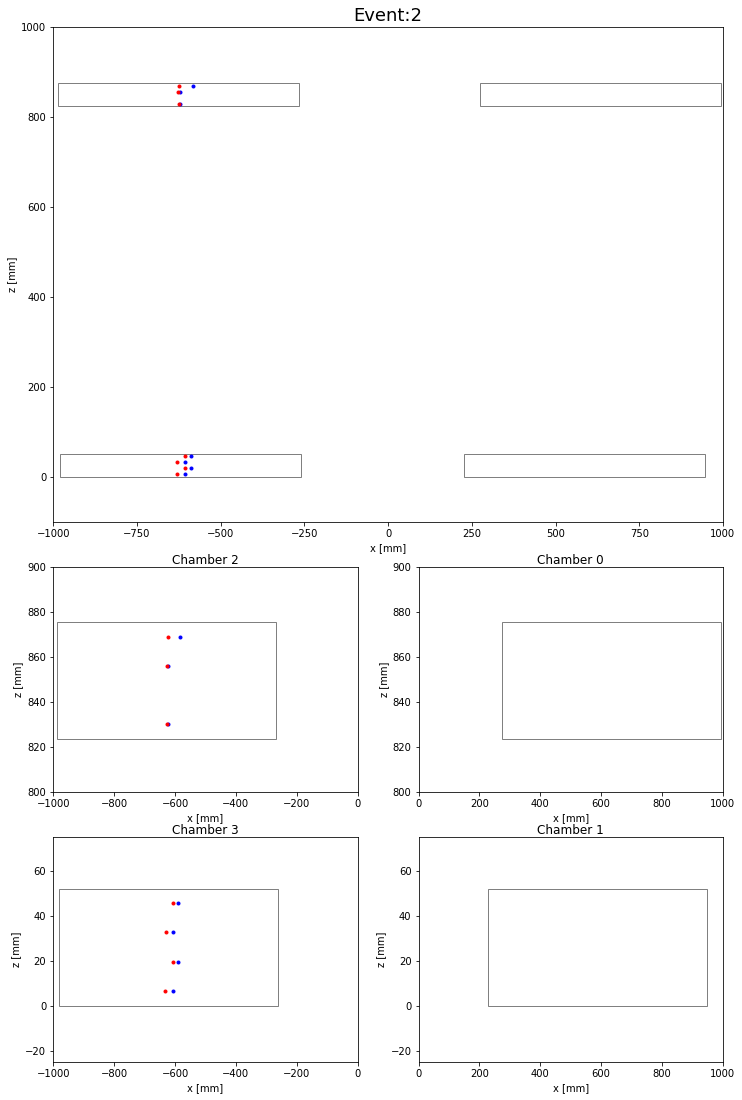

In [4]:
ev.Make_Plot()

In [5]:
data = ev.dataframe
data

,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,2,0,2,3,355.0,359.0,32.5,36.7,-622.4,-626.4,856.0
1,2,1,2,1,355.3,358.7,6.5,30.8,-622.7,-626.1,830.0
2,2,2,2,4,316.0,356.0,45.5,371.7,-583.4,-623.4,869.0
3,2,3,3,2,327.4,344.6,19.5,160.0,-588.9,-606.1,19.5
4,2,4,3,1,343.9,370.1,6.5,243.3,-605.4,-631.6,6.5
5,2,5,3,4,328.0,344.0,45.5,149.2,-589.5,-605.5,45.5
6,2,6,3,3,344.4,369.6,32.5,233.3,-605.9,-631.1,32.5


In [6]:
test = ev._Local_Fit()

In [7]:
type(test)

list

In [8]:
test

[{'slope': 0.013736263736263422,
  'intercept': 355.0464285714286,
  'optimal_comb': array([[ 32.5, 355. ],
         [  6.5, 355.3],
         [ 45.5, 356. ]]),
  'excl_layer': 0},
 {'slope': 0.004945054945055445,
  'intercept': 343.96071428571423,
  'optimal_comb': array([[  6.5, 343.9],
         [ 45.5, 344. ],
         [ 32.5, 344.4]]),
  'excl_layer': 2}]

In [9]:
test[2]['model'].pvalues

IndexError: list index out of range